In [1]:
import sys
# !{sys.executable} -m pip install pytorch torchvision cudatoolkit==10.1

In [2]:
import sys
import warnings
import math as m
import numpy as np
import pandas as pd
import tensorly as tl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf

import scipy
from scipy.linalg import hankel
from scipy.signal import find_peaks
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_normal_

from visuals import SSA, plot_phase_trajectory, delay_embedding_matrix

In [3]:
def delay_embedding_matrix(s, nlags, fit_intercept=False):
    """Make a matrix with delay embeddings.

    Parameters
    ----------
    s : np.array
        The time series data.

    nlags : int
        Size of time lags.

    Returns
    -------
    delay_embedding_matrix : np.array of shape  (len(s) - lags + 1 , lags)
        Matrix with lags.
    """ 
    N = len(s)
    delay_embedding_matrix = hankel(s[ : N - nlags + 1], s[N - nlags : N])
    if fit_intercept:
        delay_embedding_matrix = np.hstack((np.ones((delay_embedding_matrix.shape[0],1)),delay_embedding_matrix))
    return delay_embedding_matrix

def diag_mean(array):
    array = array[::-1]
    ts = [array.diagonal(j).mean() for j in range(-array.shape[0]+1, array.shape[1])]
    return ts

def prepare_time_series(path, centred = True):
    data = pd.read_csv(path, delimiter =';', decimal=',')
    
    time_series = data[['X_value', 'Y_value', 'Z_value']]
    time_series[['x axis', 'y axis', 'z axis']] = time_series[['X_value', 'Y_value', 'Z_value']]
    time_series = time_series[['x axis', 'y axis', 'z axis']]
    if centred:
        time_series = (time_series - np.mean(time_series, axis = 0))/np.std(time_series, axis = 0)
        
    time_points = (data['time'].values).astype(float).reshape([-1,])
    time_points = np.linspace(0,time_points[-1]-time_points[0],time_series.shape[0])

    return time_series,time_points

In [4]:
plt.rcParams['font.family'] = 'DejaVu Serif'

# Henon map example

In [5]:
def henon_map(x, y, a = 1, b = 1, c = 1.4, d = 0.3):
	x_n = a + b*y + c*x ** 2
	y_n = d * x
	return x_n, y_n

In [6]:
n = 1_000_000
xs, ys = [1.076], [-0.12]
for i in range(n):
    x_n, y_n = henon_map(xs[-1], ys[-1], a=1 , b=1, c=-1.4, d=0.3)
    xs.append(x_n)
    ys.append(y_n)

In [7]:
x_delay = delay_embedding_matrix(xs,2)
y_delay = delay_embedding_matrix(ys,2)

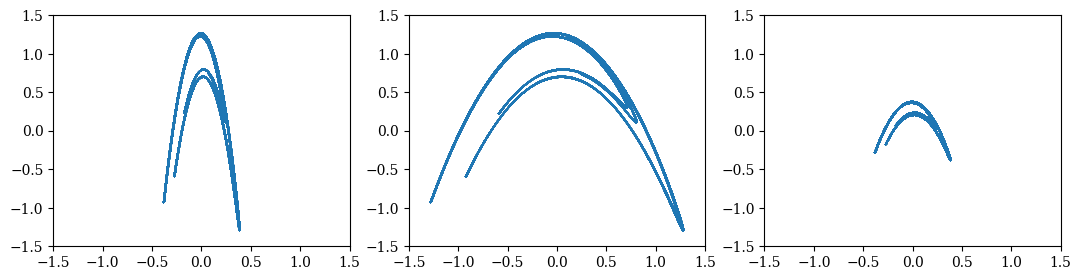

In [8]:
fig, axs = plt.subplots(figsize=(13, 3), ncols=3)
for i, x, y in [(0,ys, xs), (1,x_delay[:,0], x_delay[:,1]), (2,y_delay[:,0], y_delay[:,1])]:
    axs[i].plot(x, y, '.', markersize=0.02)
    axs[i].set_ylim(-1.5,1.5)
    axs[i].set_xlim(-1.5,1.5)

plt.savefig(f'./../resources/reconst.png', format='png', dpi=200)

# Real time series

In [43]:
class MultilinearAE(nn.Module):

    def __init__(self, x_dims, rank, attractor_dim):
        super(MultilinearAE, self).__init__()
        self.x_dims = x_dims
        self.rank = rank
        self.attractor_dim = attractor_dim
        # self.add_ones = add_ones

        self.x_weights = [Parameter(torch.Tensor(dims, self.rank).cuda()) for dims in x_dims]
        self.attractor_weights = Parameter(torch.Tensor(self.rank, self.attractor_dim).cuda())

        self.x_weights_out = [Parameter(torch.Tensor(attractor_dim, dims).cuda()) for dims in x_dims]
        
        _ = [xavier_normal_(x_weight) for x_weight in self.x_weights]
        _ = xavier_normal_(self.attractor_weights)

    def encoder(self, Xs):
        batch_size = Xs[0].shape[0]

        hidden_Xs = [torch.matmul(Xs[i], x_weight) for i, x_weight in enumerate(self.x_weights)]
        hidden_X = 0 
        for x in hidden_Xs:
            hidden_X += x
        
        S = torch.matmul(hidden_X, self.attractor_weights)
        return S

    def decoder(self, S):
        Xs_pred = [torch.matmul(S, x_weight) for i, x_weight in enumerate(self.x_weights_out)]
        return Xs_pred
        
    def forward(self, Xs):
         S = self.encoder(Xs)
         Xs_pred = self.decoder(S)
         return Xs_pred

In [47]:
def tensor_model_fit_transform(npa_Xs, attractor_dim):
    rank = 10
    x_dims = [x.shape[1] for x in npa_Xs] 
    model = MultilinearAE(x_dims, rank, attractor_dim)
    model.cuda()

    optimizer = optim.Adam(model.parameters())
    epoch = 2000 
    loss_function = nn.MSELoss()
    ta_Xs = [torch.from_numpy(x).to(torch.float).cuda() for x in npa_Xs]
    for i in range(epoch):
        loss = 0
        optimizer.zero_grad()
        ta_Xs_rec = model(ta_Xs)
        for X, X_rec in zip(ta_Xs, ta_Xs_rec):
            loss += loss_function(X, X_rec)
        loss.backward()
        optimizer.step()

    X_attract = model.encoder(ta_Xs).cpu().detach().numpy()
    return X_attract

In [50]:
def main(activity):
    result_tables_model_names = [
        'X', 'Y', 'RSS XY',
        'Stacked XY', 'Tensor XY'
    ]
     
    pdf_result_r2 = pd.DataFrame(columns=result_tables_model_names)
    pdf_result_mse, pdf_result_mape = pdf_result_r2.copy(), pdf_result_r2.copy()
    
    # for person in tqdm(np.arange(1,3)):
    for person in tqdm(np.arange(1,25)):
        _pdf_result_r2 = pd.DataFrame(columns=result_tables_model_names)
        _pdf_result_mse, _pdf_result_mape = _pdf_result_r2.copy(), _pdf_result_r2.copy()
        
        pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').loc[::freq_n].reset_index(drop=True)
        mean = pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].mean()
        var = pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].var()**.5
        pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']] = (pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]-mean)/var
        
        ############### Components TDE ####################################################
        X_tde = delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag, fit_intercept=False)[:,::freq_n]
        Y_tde = delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag, fit_intercept=False)[:,::freq_n]
        Z_tde = delay_embedding_matrix(pdf_data_all['userAcceleration.z'].to_numpy(), lag)[:,::freq_n]
    
        ##########################################################################################                         
        Xs_tde = np.array([
            delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag, fit_intercept=True)[:,::freq_n],
            delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag, fit_intercept=True)[:,::freq_n]
        ])
        
        XY_stack = np.hstack((Xs_tde[0,:,:], Xs_tde[1,:,:]))    
        ##########################################################################################
        
        pdf_root = pdf_data_all[['userAcceleration.x', 'userAcceleration.y']].copy()+20
        array_root = (pdf_root['userAcceleration.x'].to_numpy()**2 + pdf_root['userAcceleration.y'].to_numpy()**2)**.5
        array_root = (array_root - array_root.mean())/array_root.var()
        XY_rss = delay_embedding_matrix(array_root, lag)
        ##########################################################################################
        ##########################################################################################

        # for dim_n in range(2,10):
        for dim_n in range(3,21):
            ############### Simple PCA for X #########################################################
            S_attr_x = PCA(n_components=dim_n).fit_transform(X_tde)
            W_x_tde = (np.linalg.inv(S_attr_x.T@S_attr_x + l2_coef*np.identity(dim_n))@S_attr_x.T@Z_tde)
            
            ############### Simple PCA for Y #########################################################
            S_attr_y = PCA(n_components=dim_n).fit_transform(Y_tde)
            W_y_tde = (np.linalg.inv(S_attr_y.T@S_attr_y + l2_coef*np.identity(dim_n))@S_attr_y.T@Z_tde)

            ############### Simple PCA for XY ########################################################
            S_attr_stack = PCA(n_components=dim_n).fit_transform(XY_stack)
            W_stack = (np.linalg.inv(S_attr_stack.T@S_attr_stack + l2_coef*np.identity(dim_n))@S_attr_stack.T@Z_tde)
    
            ############### PCA for X and Y squared sum ##############################################
            S_attr_rss = PCA(n_components=dim_n).fit_transform(XY_rss)
            W_xy_rss = (np.linalg.inv(S_attr_rss.T@S_attr_rss + l2_coef*np.identity(dim_n))@S_attr_rss.T@Z_tde)
            
            ############### Tensor XY and PCA ########################################################
            S_attr_tensor = tensor_model_fit_transform(Xs_tde, dim_n)
            print(S_attr_tensor)
            W_tensor = (np.linalg.inv(S_attr_tensor.T@S_attr_tensor + l2_coef*np.identity(dim_n))@S_attr_tensor.T@Z_tde)
            
            ##########################################################################################
            z_ts = diag_mean(Z_tde)
            z_x_tde = diag_mean(S_attr_x@W_x_tde)
            z_y_tde = diag_mean(S_attr_y@W_y_tde)
            z_xy_stack = diag_mean(S_attr_stack@W_stack)
            z_xy_rss = diag_mean(S_attr_rss@W_xy_rss)
            z_tensor = diag_mean(S_attr_tensor@W_tensor)
            
            _pdf_result_r2.loc[dim_n, :] = [
                r2_score(z_ts, z_x_tde),
                r2_score(z_ts, z_y_tde),
                r2_score(z_ts, z_xy_stack),
                r2_score(z_ts, z_xy_rss),
                r2_score(z_ts, z_tensor)
            ]
            pdf_result_r2 = pd.concat([pdf_result_r2, _pdf_result_r2], axis=0)
            
            pdf_result_mse.loc[dim_n, :] = [
                mse(z_ts, z_x_tde)**.5,
                mse(z_ts, z_y_tde)**.5,
                mse(z_ts, z_xy_stack)**.5,
                mse(z_ts, z_xy_rss)**.5,
                mse(z_ts, z_tensor)**.5
            ]
            _pdf_result_mse = pd.concat([pdf_result_mse, _pdf_result_mse], axis=0)
    
    pdf_result_r2 = pdf_result_r2.reset_index().groupby('index').mean()
    pdf_result_mse = pdf_result_mse.reset_index().groupby('index').mean()

    ax = pdf_result_r2.plot()
    ax.set_xlabel("Attractor dimension", fontsize = 20)
    ax.set_ylabel("R2 score", fontsize = 20)
    plt.savefig(f'./figs/_1_{activity}_r2_z_axis.png', format='png', dpi=150, bbox_inches='tight')
    
    ax = pdf_result_mse.plot()
    ax.set_xlabel("Attractor dimension", fontsize = 20)
    ax.set_ylabel("Root mean square deviation", fontsize = 20)
    plt.savefig(f'./figs/_2_{activity}_mse_z_axis.png', format='png', dpi=150, bbox_inches='tight')
    
    return pdf_result_r2, pdf_result_mse

In [51]:
freq_n = 1
lag = 90
l2_coef = 0
pdf_result_r2, pdf_result_mse = main('wlk_15')

  0%|          | 0/24 [00:01<?, ?it/s]

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 ...
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


ValueError: Input contains NaN.

In [ ]:
# pdf_to_tex_r2 = pdf_result_r2.loc[[3,7,15,20,25]]
# pdf_to_tex_r2.columns = pd.MultiIndex.from_tuples([('Only X axis', 'R2'), ('Only Y axis', 'R2'),	('rSS for X,Y', 'R2'), ('Tensor X,Y', 'R2')])
# pdf_to_tex_mse = pdf_result_mse.loc[[3,7,15,20,25]]
# pdf_to_tex_mse.columns = pd.MultiIndex.from_tuples([('Only X axis', 'rMSE'), ('Only Y axis', 'rMSE'),	('rSS for X,Y' , 'rMSE'), ('Tensor X,Y', 'rMSE')])

# pdf = pd.concat([pdf_to_tex_r2,pdf_to_tex_mse], axis = 1)
# pdf = pdf.reindex(sorted(pdf.columns), axis=1)
# pdf.index.names = ['Dimension']

# column_format = 'l|'+'|'.join(['p{1cm}p{1cm}' for _ in range(int(pdf.shape[1]/2))])
# print(pdf.astype(float).to_latex(float_format="{:.2f}".format, column_format = column_format).replace('{r}', '{p{2cm}}'))

In [ ]:
pdf_result_r2, pdf_result_mse = main('jog_16')

In [ ]:
pdf_to_tex_r2 = pdf_result_r2.loc[[3,7,15,20,25]]
pdf_to_tex_r2.columns = pd.MultiIndex.from_tuples([('Only X axis', 'R2'), ('Only Y axis', 'R2'),	('rSS for X,Y', 'R2'), ('Tensor X,Y', 'R2')])
pdf_to_tex_mse = pdf_result_mse.loc[[3,7,15,20,25]]
pdf_to_tex_mse.columns = pd.MultiIndex.from_tuples([('Only X axis', 'rMSE'), ('Only Y axis', 'rMSE'),	('rSS for X,Y' , 'rMSE'), ('Tensor X,Y', 'rMSE')])

pdf = pd.concat([pdf_to_tex_r2,pdf_to_tex_mse], axis = 1)
pdf = pdf.reindex(sorted(pdf.columns), axis=1)
pdf.index.names = ['Dimension']

column_format = 'l|'+'|'.join(['p{1cm}p{1cm}' for _ in range(int(pdf.shape[1]/2))])
print(pdf.astype(float).to_latex(float_format="{:.2f}".format, column_format = column_format).replace('{r}', '{p{2cm}}'))